<a href="https://colab.research.google.com/github/ujagrati/streamlit-dashboard/blob/main/Bitcoin_Cryptocurrency_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sudalairajkumar/cryptocurrencypricehistory")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cryptocurrencypricehistory


In [ ]:
# Install any missing libraries
!pip install pandas numpy plotly seaborn matplotlib statsmodels prophet --quiet


In [ ]:
import os
import glob
import pandas as pd
import numpy as np

# Plotting
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Time series decomposition
from statsmodels.tsa.seasonal import STL

# Prophet for forecasting
from prophet import Prophet

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive to access your dataset
drive.mount('/content/drive')

# Path to your Kaggle dataset folder
data_path = "/kaggle/input/cryptocurrencypricehistory"  # Update this to your actual folder

# Initialize an empty list to hold DataFrames
list_df = []

# Loop through all CSV files
for filename in os.listdir(data_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_path, filename)
        df = pd.read_csv(file_path)

        # Parse date column with auto-format and error handling
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Drop rows where the date couldn’t be parsed
        df = df.dropna(subset=['Date'])

        # Add a column for the coin name from filename
        df['Coin'] = filename.replace(".csv", "")

        list_df.append(df)

# Combine all DataFrames into one
crypto_df = pd.concat(list_df, ignore_index=True)

# Sort the data
crypto_df = crypto_df.sort_values(by=['Coin', 'Date'])

# Preview
crypto_df.head()


Mounted at /content/drive


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Coin
13632,1,Aave,AAVE,2020-10-05 23:59:59,55.112358,49.787900,52.675035,53.219243,0.000000e+00,8.912813e+07,coin_Aave
13633,2,Aave,AAVE,2020-10-06 23:59:59,53.402270,40.734578,53.291969,42.401599,5.830915e+05,7.101144e+07,coin_Aave
13634,3,Aave,AAVE,2020-10-07 23:59:59,42.408314,35.970690,42.399947,40.083976,6.828342e+05,6.713004e+07,coin_Aave
13635,4,Aave,AAVE,2020-10-08 23:59:59,44.902511,36.696057,39.885262,43.764463,1.658817e+06,2.202651e+08,coin_Aave
13636,5,Aave,AAVE,2020-10-09 23:59:59,47.569533,43.291776,43.764463,46.817744,8.155377e+05,2.356322e+08,coin_Aave


In [ ]:
# Show first few rows
crypto_df.head(3)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Coin
13632,1,Aave,AAVE,2020-10-05 23:59:59,55.112358,49.787900,52.675035,53.219243,0.000000,8.912813e+07,coin_Aave
13633,2,Aave,AAVE,2020-10-06 23:59:59,53.402270,40.734578,53.291969,42.401599,583091.459763,7.101144e+07,coin_Aave
13634,3,Aave,AAVE,2020-10-07 23:59:59,42.408314,35.970690,42.399947,40.083976,682834.186323,6.713004e+07,coin_Aave


Exploratory Data Analysis: Comparisons and Trends

In [ ]:
# Check column names & dtypes
crypto_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 37082 entries, 13632 to 11471
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SNo        37082 non-null  int64         
 1   Name       37082 non-null  object        
 2   Symbol     37082 non-null  object        
 3   Date       37082 non-null  datetime64[ns]
 4   High       37082 non-null  float64       
 5   Low        37082 non-null  float64       
 6   Open       37082 non-null  float64       
 7   Close      37082 non-null  float64       
 8   Volume     37082 non-null  float64       
 9   Marketcap  37082 non-null  float64       
 10  Coin       37082 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 3.4+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 37082 entries, 13632 to 11471
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----        

In [ ]:
# Summary of numeric columns
crypto_df[['Open','High','Low','Close','Volume','Marketcap']].describe()


,Open,High,Low,Close,Volume,Marketcap
count,37082.000000,37082.000000,37082.000000,37082.000000,3.708200e+04,3.708200e+04
mean,985.323755,1016.058015,952.987707,987.120511,3.022542e+09,1.542943e+10
std,5088.101367,5249.503670,4907.932082,5093.703878,1.190963e+10,7.059128e+10
min,0.000086,0.000089,0.000079,0.000086,0.000000e+00,0.000000e+00
25%,0.072456,0.075664,0.069536,0.072648,4.937190e+06,2.395955e+08
50%,1.001157,1.008733,0.999850,1.001138,8.512805e+07,1.405335e+09
75%,30.459673,31.916399,28.996246,30.512205,9.388489e+08,5.159305e+09
max,63523.754869,64863.098908,62208.964366,63503.457930,3.509679e+11,1.186364e+12


In [ ]:
# Any missing values?
crypto_df.isna().sum()


,0
SNo,0
Name,0
Symbol,0
Date,0
High,0
Low,0
Open,0
Close,0
Volume,0
Marketcap,0


In [ ]:
# Number of cryptocurrencies
unique_coins = crypto_df['Name'].nunique()
print(f"Number of distinct cryptocurrencies in dataset: {unique_coins}")
print(crypto_df['Name'].unique())


Number of distinct cryptocurrencies in dataset: 23
['Aave' 'Binance Coin' 'Bitcoin' 'Cardano' 'Chainlink' 'Cosmos'
 'Crypto.com Coin' 'Dogecoin' 'EOS' 'Ethereum' 'IOTA' 'Litecoin' 'Monero'
 'NEM' 'Polkadot' 'Solana' 'Stellar' 'Tether' 'TRON' 'USD Coin' 'Uniswap'
 'Wrapped Bitcoin' 'XRP']


In [ ]:
import pandas as pd
import glob
import os

# Path to folder where your coin_*.csv files are stored
path = '/kaggle/input/cryptocurrencypricehistory'
all_files = glob.glob(os.path.join(path, 'coin_*.csv'))

dfs = []
for file in all_files:
    df = pd.read_csv(file)
    coin_name = os.path.basename(file).replace('coin_', '').replace('.csv', '')
    # Map coin file names to display names
    name_map = {
        'Aave': 'Aave',
        'BinanceCoin': 'Binance Coin',
        'Bitcoin': 'Bitcoin',
        'Cardano': 'Cardano',
        'ChainLink': 'Chainlink',
        'Cosmos': 'Cosmos',
        'CryptocomCoin': 'Crypto.com Coin',
        'Dogecoin': 'Dogecoin',
        'EOS': 'EOS',
        'Ethereum': 'Ethereum',
        'Iota': 'IOTA',
        'Litecoin': 'Litecoin',
        'Monero': 'Monero',
        'NEM': 'NEM',
        'Polkadot': 'Polkadot',
        'Solana': 'Solana',
        'Stellar': 'Stellar',
        'Tether': 'Tether',
        'Tron': 'TRON',
        'USDCoin': 'USD Coin',
        'Uniswap': 'Uniswap',
        'WrappedBitcoin': 'Wrapped Bitcoin',
        'XRP': 'XRP'
    }
    df['Name'] = name_map.get(coin_name, coin_name)
    dfs.append(df)

# Combine all into one DataFrame
crypto_df_all = pd.concat(dfs, ignore_index=True)

# Ensure date is datetime
crypto_df_all['Date'] = pd.to_datetime(crypto_df_all['Date'])

# Preview
print(crypto_df_all[['Date', 'Name', 'Marketcap']].head())


                 Date       Name   Marketcap
0 2017-09-21 23:59:59  Chainlink  59388000.0
1 2017-09-22 23:59:59  Chainlink  52676050.0
2 2017-09-23 23:59:59  Chainlink  45895150.0
3 2017-09-24 23:59:59  Chainlink  59597300.0
4 2017-09-25 23:59:59  Chainlink  63769300.0


In [ ]:
# Data range per currency
date_range = crypto_df.groupby('Name')['Date'].agg(['min','max'])
date_range.rename(columns={'min':'Start','max':'End'}, inplace=True)
date_range


,Start,End
Name,,
Aave,2020-10-05 23:59:59,2021-07-06 23:59:59
Binance Coin,2017-07-26 23:59:59,2021-07-06 23:59:59
Bitcoin,2013-04-29 23:59:59,2021-07-06 23:59:59
Cardano,2017-10-02 23:59:59,2021-07-06 23:59:59
Chainlink,2017-09-21 23:59:59,2021-07-06 23:59:59
Cosmos,2019-03-15 23:59:59,2021-07-06 23:59:59
Crypto.com Coin,2018-12-15 23:59:59,2021-07-06 23:59:59
Dogecoin,2013-12-16 23:59:59,2021-07-06 23:59:59
EOS,2017-07-02 23:59:59,2021-07-06 23:59:59


In [ ]:
# Question 1: How did the historical prices / market capitalizations of various currencies change over time?
selected = ['Aave', 'Binance Coin', 'Bitcoin', 'Cardano', 'Chainlink', 'Cosmos',
 'Crypto.com Coin', 'Dogecoin', 'EOS', 'Ethereum', 'IOTA', 'Litecoin',
 'Monero', 'NEM', 'Polkadot', 'Solana', 'Stellar', 'Tether', 'TRON',
 'USD Coin', 'Uniswap', 'Wrapped Bitcoin', 'XRP']


fig = px.line(
    crypto_df[crypto_df['Name'].isin(selected)],
    x='Date', y='Close', color='Name',
    title="Closing Price Over Time for Selected Cryptocurrencies",
    labels={'Close':'Price (USD)', 'Date':'Date'}
)
fig.update_layout(legend_title_text='Name')
fig.show()


Because some coins start with very low price (e.g., pennies) and others (like BTC) reach thousands, a log scale helps see all curves on one plot:

In [ ]:
#Log-scaled price curves
fig = px.line(
    crypto_df[crypto_df['Name'].isin(selected)],
    x='Date', y='Close', color='Name',
    log_y=True,
    title="Log-Scale: Closing Price Over Time",
    labels={'Close':'Price (USD) (log scale)', 'Date':'Date'}
)
fig.update_layout(legend_title_text='Name')
fig.show()


In [ ]:
# Market cap analysis (Selected vs rest) : Dynamic
import pandas as pd
import plotly.graph_objects as go

def plot_marketcap_vs_rest(data, selected_coin):

    # Ensure Date is datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Sum total market cap by date
    daily_total_mc = data.groupby('Date')['Marketcap'].sum().reset_index(name='Total_MarketCap')

    # Extract selected coin's market cap
    coin_mc = data[data['Name'] == selected_coin][['Date', 'Marketcap']].rename(columns={'Marketcap': f'{selected_coin}_MarketCap'})

    # Merge and compute rest-of-market cap
    mc_merged = pd.merge(daily_total_mc, coin_mc, on='Date', how='left')
    mc_merged[f'{selected_coin}_MarketCap'] = mc_merged[f'{selected_coin}_MarketCap'].fillna(0)
    mc_merged['Others_MarketCap'] = mc_merged['Total_MarketCap'] - mc_merged[f'{selected_coin}_MarketCap']

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=mc_merged['Date'], y=mc_merged[f'{selected_coin}_MarketCap'],
        mode='lines', name=f'{selected_coin} MC'
    ))
    fig.add_trace(go.Scatter(
        x=mc_merged['Date'], y=mc_merged['Others_MarketCap'],
        mode='lines', name='Rest of Market MC'
    ))
    fig.update_layout(
        title=f"{selected_coin} vs. Rest of Crypto Market Cap Over Time",
        xaxis_title="Date", yaxis_title="Market Cap (USD)",
        legend_title="Legend",
        height=600
    )
    fig.show()

# Usage:
coin_list = ['Aave', 'Binance Coin', 'Bitcoin', 'Cardano', 'Chainlink', 'Cosmos',
             'Crypto.com Coin', 'Dogecoin', 'EOS', 'Ethereum', 'IOTA', 'Litecoin',
             'Monero', 'NEM', 'Polkadot', 'Solana', 'Stellar', 'Tether', 'TRON',
             'USD Coin', 'Uniswap', 'Wrapped Bitcoin', 'XRP']

# Example: Compare Ethereum vs rest
plot_marketcap_vs_rest(data=crypto_df_all, selected_coin='TRON')


Volatility Analysis

In [ ]:
# Sort by currency & date first (already sorted earlier)
crypto_df['Return'] = crypto_df.groupby('Symbol')['Close'].pct_change()  # (Today/Yesterday−1)


In [ ]:
# Check a few rows
crypto_df[['Symbol','Date','Close','Return']].head(10)


,Symbol,Date,Close,Return
13632,AAVE,2020-10-05 23:59:59,53.219243,NaN
13633,AAVE,2020-10-06 23:59:59,42.401599,-0.203266
13634,AAVE,2020-10-07 23:59:59,40.083976,-0.054659
13635,AAVE,2020-10-08 23:59:59,43.764463,0.091819
13636,AAVE,2020-10-09 23:59:59,46.817744,0.069766
13637,AAVE,2020-10-10 23:59:59,49.133718,0.049468
13638,AAVE,2020-10-11 23:59:59,49.660726,0.010726
13639,AAVE,2020-10-12 23:59:59,52.238692,0.051912
13640,AAVE,2020-10-13 23:59:59,51.124317,-0.021332
13641,AAVE,2020-10-14 23:59:59,51.316518,0.003759


In [ ]:
#Overall volatility, Q3) Which currencies are more volatile and which ones are more stable?
volatility_whole = crypto_df.groupby('Symbol')['Return'].std().sort_values(ascending=False)
volatility_whole = volatility_whole.reset_index(name='StdDev_Returns')
volatility_whole.head(23)


,Symbol,StdDev_Returns
0,DOGE,0.113458
1,TRX,0.095264
2,SOL,0.094507
3,UNI,0.091299
4,DOT,0.087181
5,XEM,0.086892
6,AAVE,0.086548
7,ADA,0.083598
8,XRP,0.081566
9,XLM,0.081531


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rolling_volatility(data, coin_name, window=365):
    """
    Plot rolling annualized volatility for a given cryptocurrency.

    Parameters:
    - data: DataFrame containing all coins' historical data.
    - coin_name: Name of the cryptocurrency (must match 'Name' column).
    - window: Rolling window size in days (default is 365).
    """
    coin_data = data[data['Name'] == coin_name].copy()

    # Calculate daily returns
    coin_data['Return'] = coin_data['Close'].pct_change()

    # Calculate rolling volatility and annualize
    coin_data['Volatility'] = coin_data['Return'].rolling(window=window).std() * np.sqrt(365)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(coin_data['Date'], coin_data['Volatility'], label=f'{window}-Day Rolling Volatility')
    plt.title(f'{coin_name} Annualized Volatility Over Time ({window}-Day Rolling Window)')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


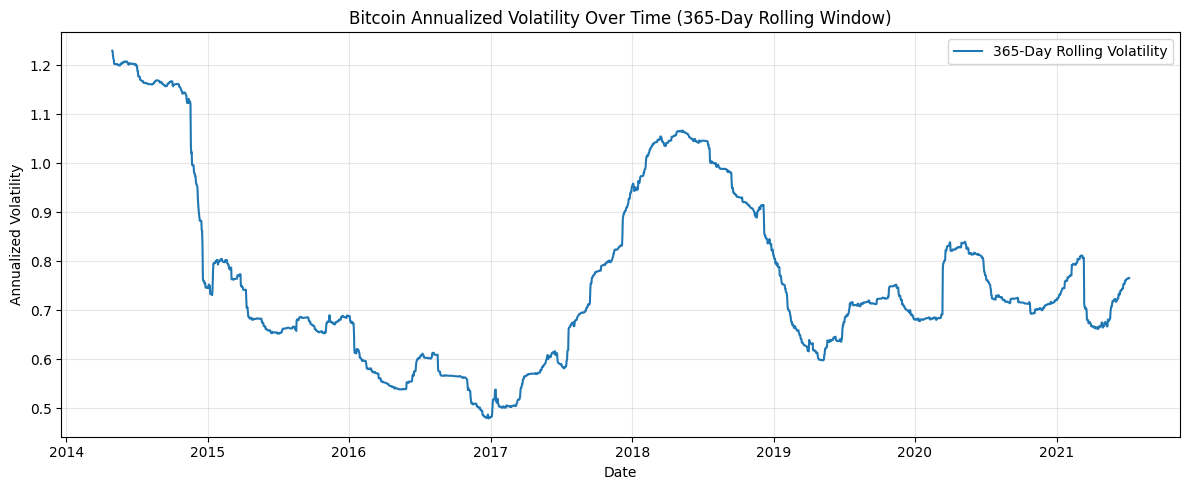

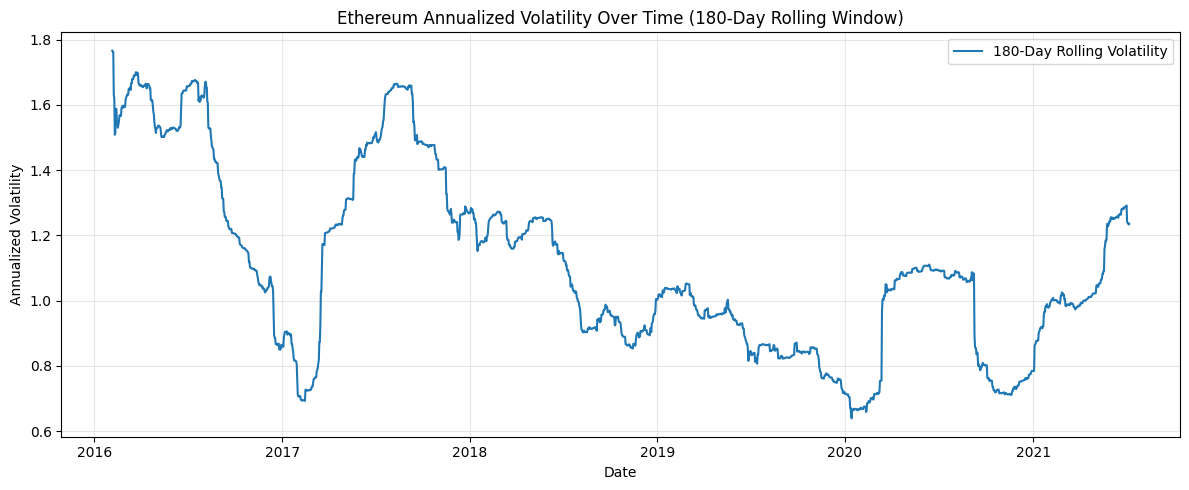

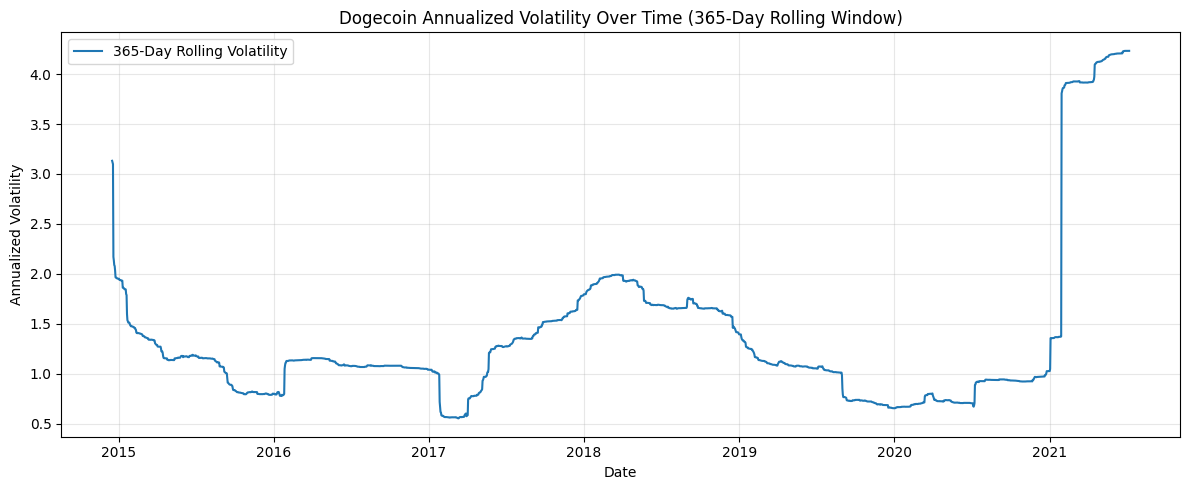

In [ ]:
plot_rolling_volatility(crypto_df_all, 'Bitcoin')
plot_rolling_volatility(crypto_df_all, 'Ethereum', window=180) #Window-based ex.
plot_rolling_volatility(crypto_df_all, 'Dogecoin')


In [ ]:
#Correlation Analysis / Q4: How does the price fluctuations of currencies correlate with each other?
price_pivot = crypto_df.pivot_table(index='Date', columns='Symbol', values='Close')
price_pivot.head(3)




Symbol,AAVE,ADA,ATOM,BNB,BTC,CRO,DOGE,DOT,EOS,ETH,...,SOL,TRX,UNI,USDC,USDT,WBTC,XEM,XLM,XMR,XRP
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,NaN,NaN,NaN,NaN,144.539993,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30 23:59:59,NaN,NaN,NaN,NaN,139.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01 23:59:59,NaN,NaN,NaN,NaN,116.989998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


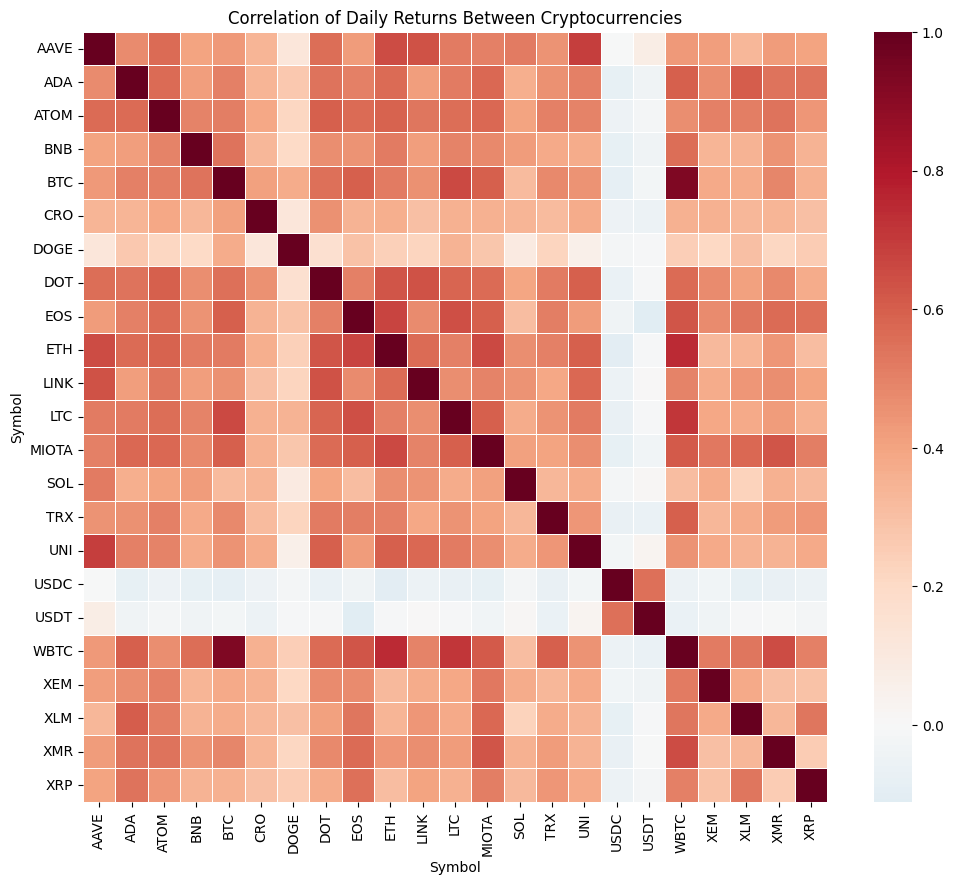

In [43]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, linewidths=0.5)
plt.title('Correlation of Daily Returns Between Cryptocurrencies')
plt.show()


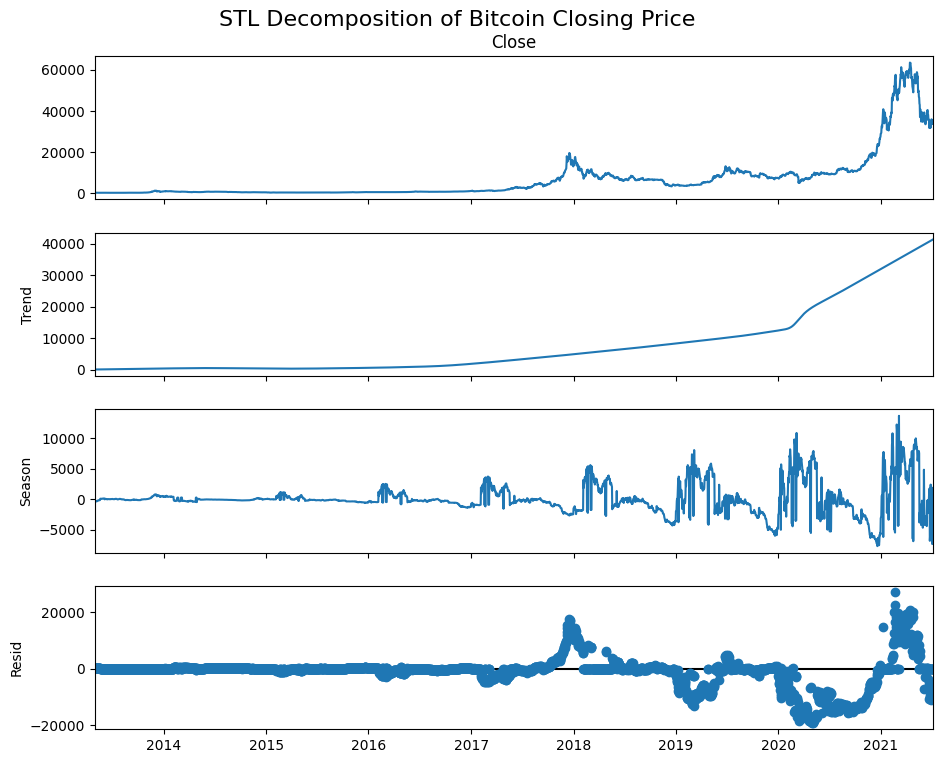

In [45]:
#seasonality and future
# Reindex to include every calendar date, then forward-fill missing closes
btc = crypto_df[crypto_df['Name']=='Bitcoin'][['Date','Close']].set_index('Date')
all_days = pd.date_range(start=btc.index.min(), end=btc.index.max(), freq='D')
btc = btc.reindex(all_days)
btc['Close'].ffill(inplace=True)  # fill weekends/holidays

# Perform STL decomposition with a 365-day seasonal window
stl = STL(btc['Close'], period=365, robust=True)
res = stl.fit()

# Plot components
fig = res.plot()
fig.set_size_inches(10, 8)
plt.suptitle('STL Decomposition of Bitcoin Closing Price', fontsize=16)
plt.show()


In [46]:
#forecast using prophet
#Prepare Data for Prophet
btc_prophet = crypto_df[crypto_df['Name']=='Bitcoin'][['Date','Close']].rename(columns={'Date':'ds','Close':'y'})

# Prophet works best if there are no missing dates—let’s ensure that
# (similar to STL step, reindex calendar, fill missing y with last known)
btc_prophet = btc_prophet.set_index('ds').asfreq('D')
btc_prophet['y'].ffill(inplace=True)
btc_prophet = btc_prophet.reset_index()

btc_prophet.head(3)


,ds,y
0,2013-04-29 23:59:59,144.539993
1,2013-04-30 23:59:59,139.000000
2,2013-05-01 23:59:59,116.989998


In [47]:
#Fit Prophet & Make Forecast
m = Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(btc_prophet)

# Create a future dataframe for 30 days ahead
future = m.make_future_dataframe(periods=30, freq='D')
forecast = m.predict(future)

# Show the forecast tail
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8yyrutt/k_894ffm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8yyrutt/x7unes70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32957', 'data', 'file=/tmp/tmpg8yyrutt/k_894ffm.json', 'init=/tmp/tmpg8yyrutt/x7unes70.json', 'output', 'file=/tmp/tmpg8yyrutt/prophet_modelmjgx65_6/prophet_model-20250603071952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:19:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
3016,2021-08-01 23:59:59,44235.388341,37949.547429,50199.350207
3017,2021-08-02 23:59:59,44305.093617,38406.277419,50511.135863
3018,2021-08-03 23:59:59,44366.285837,38334.006493,49790.180539
3019,2021-08-04 23:59:59,44450.263746,38019.547786,50887.843684
3020,2021-08-05 23:59:59,44506.332547,38181.779146,50436.516631


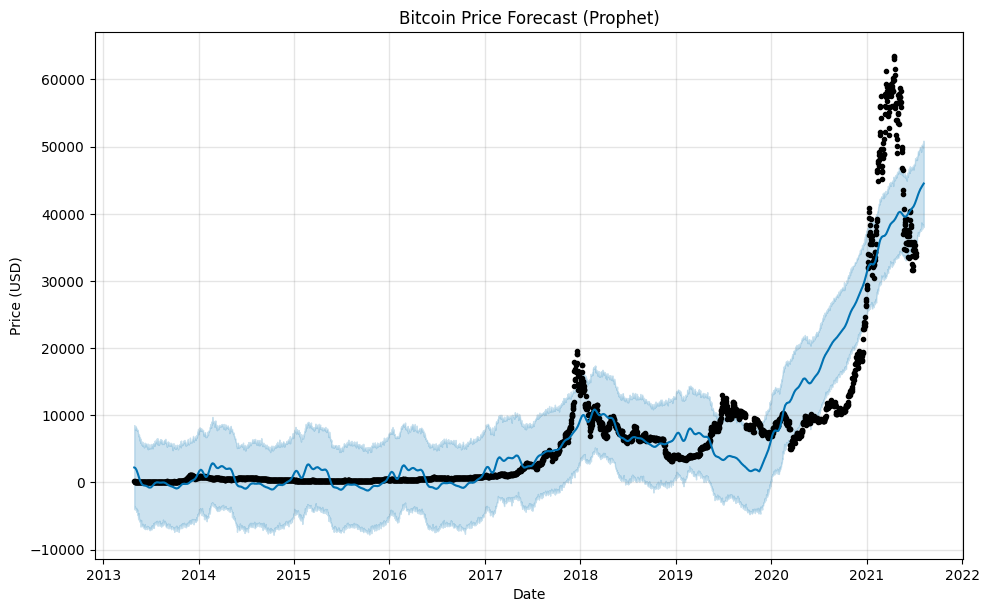

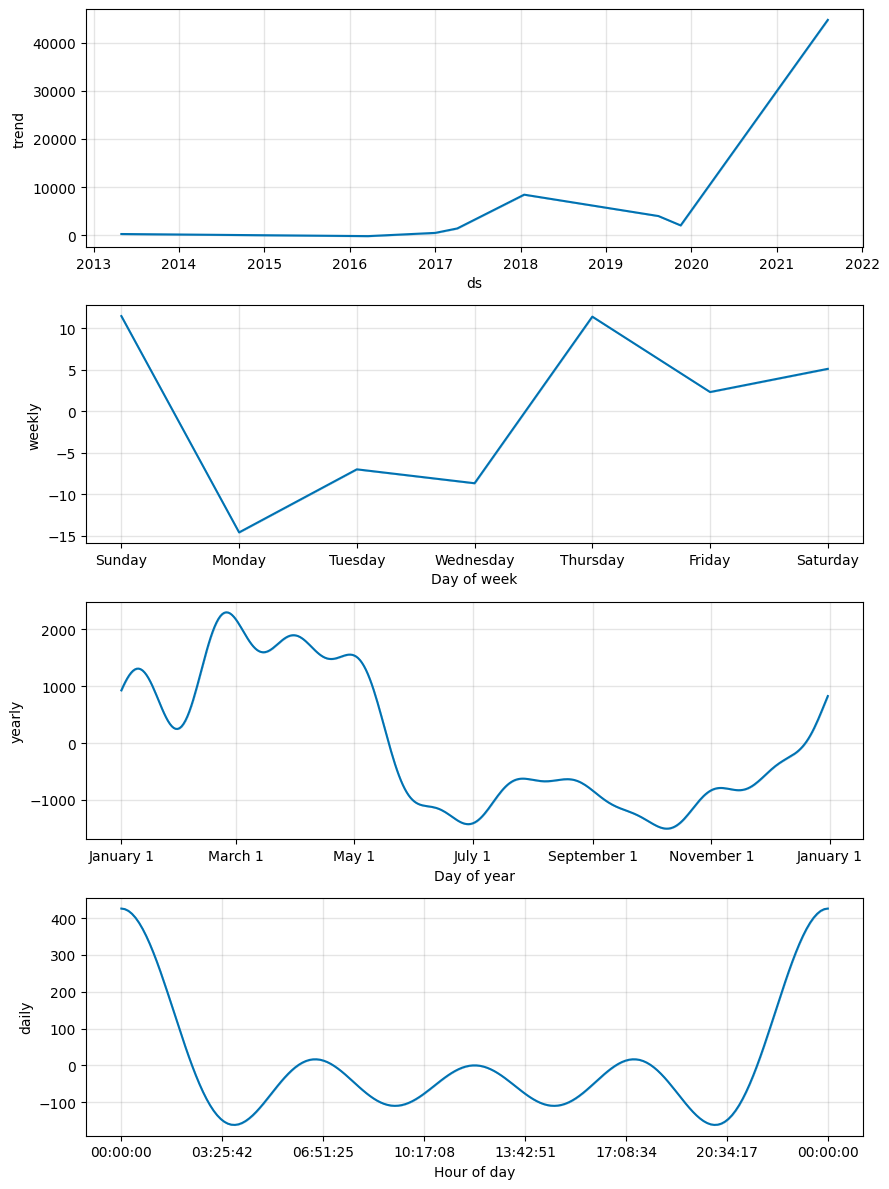

In [48]:
# Visualize Forecast & Components
fig1 = m.plot(forecast)
plt.title("Bitcoin Price Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

'''
The blue line is the model’s fitted + forecasted values.

The light blue band shows uncertainty intervals.

Components plot shows overall trend, yearly seasonality , and weekly seasonality.'''


In [50]:
#Most volatile vs Most stable
volatility_whole = volatility_whole.sort_values(by='StdDev_Returns', ascending=False)
volatility_whole.head(10)  # top 10 most volatile
volatility_whole.tail(10)  # top 10 least volatile (most stable)


,Symbol,StdDev_Returns
13,EOS,0.075459
14,MIOTA,0.073553
15,ATOM,0.071993
16,XMR,0.069837
17,LTC,0.068532
18,ETH,0.063036
19,WBTC,0.042857
20,BTC,0.042639
21,USDT,0.017736
22,USDC,0.004592


In [53]:
#streamlit dashboard for visualisation
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00


In [54]:
crypto_df.to_csv('cleaned_crypto.csv', index=False)


In [55]:
from google.colab import files
files.download('cleaned_crypto.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
!streamlit run streamlit_app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: streamlit_app.py
